In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import folium
from folium import utilities
from pyppeteer import launch

In [4]:
plt.rc('font',family="NanumGothic")

In [7]:
sdf_excel = pd.read_excel("../data/saramin_df.xlsx",engine="openpyxl")

In [8]:
sdf_excel.drop(columns=["Unnamed: 0"],inplace=True)

In [9]:
sdf_excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   회사명         1665 non-null   object 
 1   직무          1665 non-null   object 
 2   URL         1665 non-null   object 
 3   근무지         1665 non-null   object 
 4   경력          1665 non-null   object 
 5   학위          1659 non-null   object 
 6   사내복지        1037 non-null   object 
 7   기업 정보       1645 non-null   object 
 8   지원자 통계      1117 non-null   object 
 9   세부정보        1647 non-null   object 
 10  ML/DL       1665 non-null   int64  
 11  로봇 설계 및 제작  1665 non-null   int64  
 12  ROS         1665 non-null   int64  
 13  임베디드        1665 non-null   int64  
 14  자율주행        1665 non-null   int64  
 15  제어          1665 non-null   int64  
 16  기업 주소       1645 non-null   object 
 17  위도          1665 non-null   float64
 18  경도          1665 non-null   float64
dtypes: float64(2), int64(6), ob

In [ ]:
# 학위 그룹화
# sdf_excel.loc[sdf_excel["학위"]=="대졸","학위"] = "대졸↑"

In [ ]:
# # 경력 그룹화
# sdf_excel.loc[sdf_excel["경력"]=="경력 10~20년","경력"] = "경력 10년↑"
# sdf_excel["경력"].unique()

전체 고용건에서 학위별 요구조건 비율을 시각화

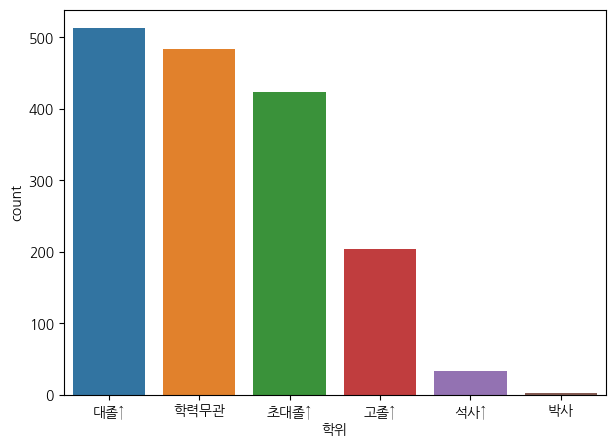

In [13]:
plt.figure(figsize=(7,5))
sns.countplot(data=sdf_excel,x="학위",order=sdf_excel["학위"].value_counts().index);
plt.savefig("../data/all_degree.png",transparent=True)

In [14]:
sdf_deg_exp = sdf_excel[["학위","경력","회사명"]].groupby(["학위","경력"]).count().unstack()
sdf_deg_exp.fillna(0)

회사명                                          
경력   경력 10년↑ 경력 1년↑ 경력 3년↑ 경력 5년↑  경력 무관    신입 신입 및 경력
학위                                                    
고졸↑      1.0   24.0   31.0   24.0   86.0  12.0    26.0
대졸↑     22.0   68.0  120.0   86.0  124.0  14.0    79.0
박사       0.0    0.0    0.0    0.0    2.0   0.0     0.0
석사↑      2.0    5.0    7.0    4.0    6.0   3.0     6.0
초대졸↑     8.0   54.0   69.0   33.0  174.0  17.0    69.0
학력무관     5.0   49.0   61.0   32.0  273.0   9.0    54.0

<AxesSubplot: xlabel='학위'>

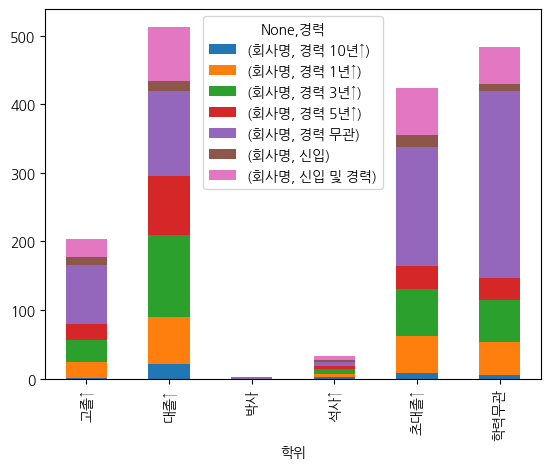

In [15]:
sdf_deg_exp.plot.bar(stacked=True)

공고중 학력이 대졸이상인 공고중에서 요구하는 경력별 전체 공고 비율 시각화

In [16]:
sdf_bach = sdf_excel.loc[sdf_excel["학위"]=="대졸↑"]

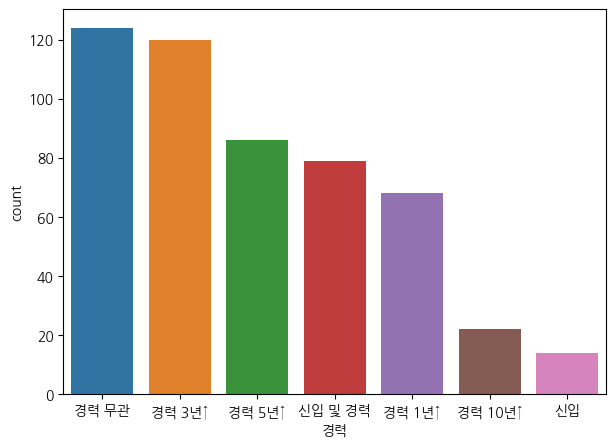

In [18]:
plt.figure(figsize=(7,5))
sns.countplot(data=sdf_bach,x=sdf_bach["경력"],order=sdf_bach["경력"].value_counts().index);
plt.savefig("../data/bachelor_exp2.png",transparent=True)

키워드 비율 시각화

In [21]:
df_auto = sdf_excel[sdf_excel['자율주행']==1]
df_ml = sdf_excel[sdf_excel['ML/DL']==1]
df_ros = sdf_excel[sdf_excel['ROS']==1]
df_dsg = sdf_excel[sdf_excel['로봇 설계 및 제작']==1]
df_emb = sdf_excel[sdf_excel['임베디드']==1]
df_ctr = sdf_excel[sdf_excel['제어']==1]

In [23]:
print(len(df_auto), len(df_ctr), len(df_dsg), len(df_emb), len(df_ml), len(df_ros))

210 681 312 266 398 139


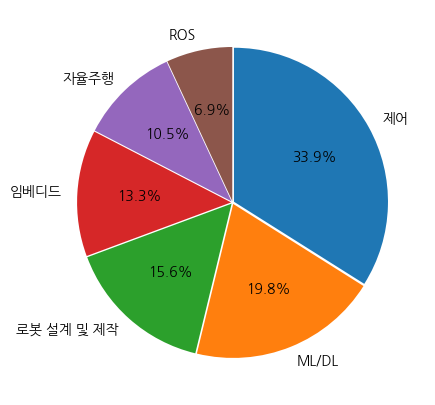

In [24]:
plt.figure(figsize=(7,5))
num = [681, 398, 312, 266, 210, 139]
labels = ["제어","ML/DL","로봇 설계 및 제작","임베디드","자율주행","ROS"]
plt.pie(num, labels=labels, autopct = '%.1f%%',startangle=90,explode=[0.01,0.01,0.01,0.01,0.01,0.01],counterclock = False);
plt.savefig("../data/all_tag_ratio_pie.png",transparent=True)

In [ ]:
# plt.title("전체 고용 건 내 머신러닝/딥러닝 요구조건 포함 비율")
# plt.pie(sdf_excel["ML/DL"].value_counts(), labels = ["ML/DL 미포함","ML/DL 포함"],colors = sns.color_palette("RdYlGn",5),\
#         counterclock = False, autopct = '%.1f%%',startangle=90,explode=[0.01,0.01]);
# plt.savefig("../data/mldl.png",transparent=True)

지도 시각화

In [ ]:
sdf_excel["수정된 주소"] = np.nan
sdf_excel["수정된 주소"].replace(np.nan,"",inplace=True)
sdf_excel["기업 정보"].replace(np.nan,"",inplace=True)

In [ ]:
for i in range(len(sdf_excel)):
    sdf_excel["수정된 주소"][i] = sdf_excel["기업 정보"][i][sdf_excel["기업 정보"][i].find("기업주소") + 5:len(sdf_excel["기업 정보"][i])]

In [ ]:
def get_address(x):
    x1 = x.split(' ')
    return " ".join(x1[0:4])

In [ ]:
sdf_excel["기업 주소"] = sdf_excel["수정된 주소"].apply(get_address)

In [ ]:
sdf_excel["기업 주소"] = sdf_excel["기업 주소"].str.strip(',')

In [ ]:
sdf_excel.to_excel("../data/saramin_df_test2.xlsx",engine="xlsxwriter")

In [ ]:
geo_local = Nominatim(user_agent='South Korea')

#위도 반환 함수
def geocoding_lat(address):
    try:
        geo = geo_local.geocode(address)
        return geo.latitude

    except:
        return 0

#경도 반환 함수
def geocoding_lon(address):
    try:
        geo = geo_local.geocode(address)
        return geo.longitude

    except:
        return 0

In [ ]:
sdf_excel['위도'] = sdf_excel['기업 주소'].apply(geocoding_lat)

In [ ]:
sdf_excel['경도'] = sdf_excel['기업 주소'].apply(geocoding_lon)

In [ ]:
sdf_excel.head()

In [26]:
my_map = folium.Map(location=[36,127],zoom_start=7, tiles="cartodbpositron")
for i in range(len(sdf_excel)):
    folium.Marker(location=[sdf_excel['위도'][i],sdf_excel['경도'][i]],
                popup=sdf_excel['URL'][i],
                icon=folium.Icon(icon="info-sign")).add_to(my_map)
my_map

In [25]:
async def map_to_png(target, m):
    html = m.get_root().render()
    browser = await launch(headless=True)

    page = await browser.newPage()
    with utilities.temp_html_filepath(html) as fname:
        await page.goto('file://{path}'.format(path=fname))

    img_data = await page.screenshot({'path': f'out_{target}.png', 'fullPage': 'true', })
    await browser.close()

In [27]:
my_map.save('marker.html')
await map_to_png('marker_all_tag', my_map)

[INFO] Starting Chromium download.
100%|██████████| 109M/109M [00:01<00:00, 86.0Mb/s] 
[INFO] Beginning extraction
[INFO] Chromium extracted to: /home/lyj/.local/share/pyppeteer/local-chromium/588429
